# Exercise II report

Ioannis-Rafail Tzonevrakis

## Important notice

**This notebook uses parallel processing**

In order to avoid overusing your CPU, or potentially locking up your system, please define the maximum number of threads to be used by this notebook below:

In [1]:
N_THREADS = 5

## Introduction
The aim of this exercise was to implement a Gibbs sampler to discover motifs in DNA sequences. This randomized sampler creates an initial Position Weight Matrix (PWM) from a random sub-sequence of length `k` from each input sequence, and then proceeds to update it with the best-scoring sub-sequences from each sequence until either its total information content, given by $H(A) = 2-\sum^{k}_{i=1}\sum^{4}_{j=1}(A_{ij}\cdot log_{2}A_{ij})$, exceeds a limit $H_lim$, or the number of iterations exceeds a predefined maximum. We apply the implemented Gibbs sampler in a test set of 50 sequences, for motif lengths k=1 to 7, and evaluate the algorithm's convergence.

## Read sequences
As the input sequence file is formatted to contain one sequence per file, it may be read as follows:

In [2]:
# Initialize sequence array
sequences = []
# Iterate over every line and append it to the sequence array, removing
# trailing newline:
with open('assets/motifs_in_sequence.fa') as fp:
    for line in fp:
        sequences.append(line.strip())

## Perform Gibbs sampling

The Gibbs sampler. along with various utilities for handling PWMs has been implemented in the `PWMUtils.py`, which has been extensively annotated with comments and type hints, and which the reader is urged to consult for implementation details; We import the relevant function and execute the sampling for each `k`:


In [3]:
from PWMUtils import gibbs_sampler
# PWM dictionary, to simplify keeping track of motif length
pwms = {}
for k in range(3, 8):
    # Define a threshold, some amount below the theoretical maximum; If it's
    # unachievable, the default iteration limit of 1000 is going to kick in
    thres = 2*k-0.6
    pwms[k] = gibbs_sampler(sequences=sequences, thres=thres, k=k)

We find and report the PWM with the maximum scaled information content as follows:

In [4]:
# Find maximum scaled information content and report it, along with the motif length k and the PWM:
max_k = max([[k, pwms[k].pwm, pwms[k].get_entropy()[2]] for k in pwms.keys()], key=lambda x: x[2])
print(f'A maximum scaled information content of {max_k[2]} was attained for k={max_k[0]}, with the following PWM:')
print(max_k[1])

A maximum scaled information content of 1.5672599360037134 was attained for k=3, with the following PWM:
[[0.   0.2  0.02]
 [1.   0.7  0.  ]
 [0.   0.1  0.98]
 [0.   0.   0.  ]]


## Evaluating the information content landscape
Since the Gibbs sampler algorithm is non-deterministic, the initial configuration may influence the final performance of the algorithm; Instead of reaching the global information maximum, it may end up being trapped in a local one. Additionally, the motif landscape of the input sequences may contain multiple global information maxima. One tool we can use to evaluate the information landscape of the input sequences for various motif lengths `k` is a [funnel plot](https://www.sciencedirect.com/science/article/pii/S0969212608000099). Since we do not know what the actual PWM is, we instead plot the scaled information content of each PWM versus its Euclidean distance to the PWM with the highest information content; This should be sufficient to check for the presence of local maxima and see the general shape of the information content landscape. First, we execute the Gibbs sampler 1000 times for each `k`, and then we plot the actual funnel plots:

In [5]:
from functools import partial
import multiprocessing as mp
from multiprocessing import Pool
from nbtools import multiseed_gibbs

# Set multiprocessing start method to spawn for Windows compatibility
# See:
# https://docs.python.org/3/library/multiprocessing.html#contexts-and-start-methods
mp.set_start_method('spawn')

# Create partial function for compatibility with the map method
partial_multiseed_gibbs = partial(multiseed_gibbs, sequences=sequences, n=1000)

with Pool(N_THREADS) as pool:
    # Parallel map the partial function to create one thread per
    # requested motif length:

    pwms_multi = pool.map(partial_multiseed_gibbs, range(3, 8))

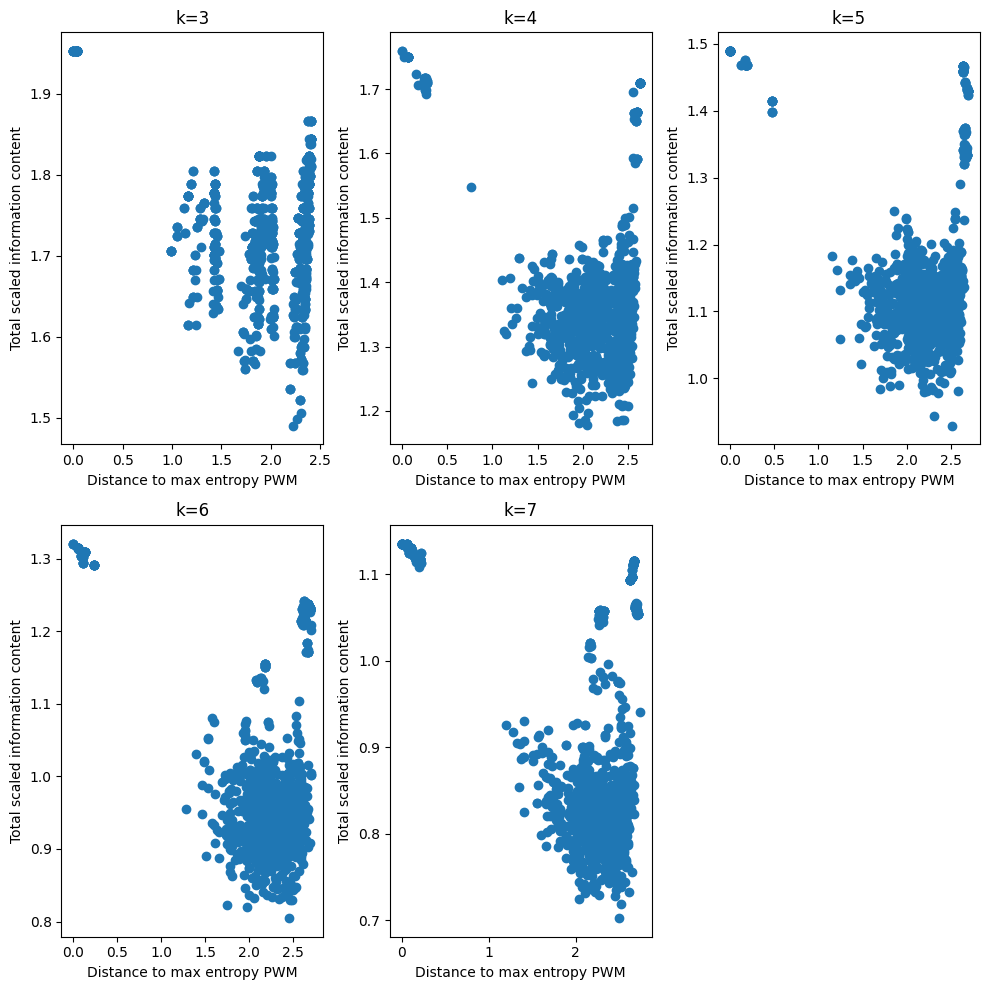

In [6]:
import numpy as np
import matplotlib.pyplot as plt
# Create funnel plots:
# Initialize matplotlib figure
plt.figure(figsize=(10,10))
# For each motif length k:
for i in range(0, len(pwms_multi)):
    # Place the plot in a 2x3 grid
    plt.subplot(2,3, i+1)
    # Get the total information content of each of the sampled PWMs
    information_content = [pwm.get_entropy()[2] for pwm in pwms_multi[i]]
    # Get the PWMs themselves
    pwms = [pwm.pwm for pwm in pwms_multi[i]]
    # Find the PWM with the maximum total information content
    maxic = information_content.index(max(information_content))
    # Get the Euclidean distances from the PWM with the maximum total information content
    dists = [np.linalg.norm(pwm.pwm - pwms_multi[i][maxic].pwm) for pwm in pwms_multi[i]]
    # Draw the scatterplot
    plt.scatter(dists, information_content)
    plt.ylabel('Total scaled information content')
    plt.xlabel('Distance to max entropy PWM')
    plt.title(f'k={i+3}')
# Clean up the layout
plt.tight_layout()

We observe that, for all `k`, there exists a single global information content maximum. However, it appears that most of the runs end up in a local maximum, typically in the range of $[1.0, 2.0]$. Additionally, it appears that, for all `k`, there exist local maxima that are close to the global maximum, but have a high Euclidean distance to the PWM that corresponds to said global maximum. Finally, the plot is not funnel-shaped, which means that it is not possible for the sampler to converge to a global information content maximum once it has been trapped in a local minimum. We can compare the PWM with the maximum scaled information content found by sampling 1000 times for each `k` with the result we obtained above:

In [7]:
max_k_multi = max([max([[k+3,
                         pwm.get_entropy()[2],
                         pwm.pwm] for pwm in pwms_multi[k]], # For each motif length, get the PWM with the
                                                             # maximum information content
                       key=lambda x: x[1]) for k in range(0, len(pwms_multi))],
                  key=lambda x: x[1]) # Then, get the PWM with the maximum information content
                                      # out of all the obtained PWMs


In [8]:
print(f'With 1000 runs for each k, a maximum scaled information content of {max_k_multi[1]} was attained for k={max_k_multi[0]}, with the following PWM:')
print(max_k_multi[2])

With 1000 runs for each k, a maximum scaled information content of 1.9528531524860597 was attained for k=3, with the following PWM:
[[0.   1.   0.  ]
 [0.   0.   0.  ]
 [0.98 0.   0.  ]
 [0.02 0.   1.  ]]


It appears that, even though the optimal `k` was found, the initial run converged to a local maximum, which, although close to the global one total scaled information content-wise, leads to a fairly different PWM. Therefore, we conclude that the Gibbs sampling algorithm may require improvements to allow it to escape from a local maximum.